## Camera fotográfica 1D

Previamente, usamos as bibliotecas pygame e pymunk para gerar um ambiente virtual e simular uma caixa sendo cheia de peças, mas para representar a natureza real da oclusão de peças, precisamos de uma foto 1D de um cenario 2D, onde parte da informação é perdida.

### Bibiliotecas e definições

In [14]:
import cv2
import numpy as np
import os
import natsort
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

### A função Camera1D

Implementa uma tirada da foto de cima da caixa com uma camera com sensor de profundidade. A foto tem dimensão 1x1024x4, onde dos 4 canais finais, os primeiros 3 guardam os valores de B, G e R e o ultimo o valor de profundidade.

A Camera implementa a versão unidimensional da projeção ortográfica, com o foco da camera no infinito. Assim podemos, nesse cenário controlado, ter a melhor representação possivel por uma imagem, com o minimo de informação perdida.

Uma função chamada unstranform visa reprojetar a imagem 2d com canal de profundidade para demonstrar a informação perdida ao batermos a foto.

In [15]:
def Camera1D(image):
    #lista para guardar as profundidades a medida que vamos escaneando horizontalmente a imagem 
    depth=[]
    #lista para guardar as cores a medida que vamos escaneando horizontalmente a imagem 
    color=[]

    #pixel branco usado em comparações
    white_pixel=np.ones((3), np.uint8)
    white_pixel=white_pixel*255
    
    #para cada coluna de pixels x
    for x in range(image.shape[1]):
        #considere que ainda não atingiu nada
        tgtflag=False
        
        #desça ao longo da coluna x[n] iterando pelos valores de y
        for y in range(image.shape[0]):
            #ignore pixels brancos
            if np.array_equal(image[y,x,:], white_pixel):
                pass
            
            #mas adicione o valor da profundidade e da cor nas listas quando atinge algo
            else:
                depth.append(np.array([[y]]))
                color.append(np.expand_dims(np.expand_dims(image[y,x,:], axis=0),axis=0))
                tgtflag=True
                #e pare a descida da coluna x[n]
                break
                
        #se não atingiu algo (peça), retorne a profundidade maxima e o valor branco
        if tgtflag==False:
            depth.append(np.array([[y]]))
            color.append(np.expand_dims(np.expand_dims(white_pixel, axis=0),axis=0))

    #transforme as listas em arrays
    color=np.concatenate( color, axis=1 )
    depth=np.concatenate( depth, axis=1 )
    depth=np.expand_dims(depth, axis=2)

    #inverte a função de salvar a profundidade para salvar como se fosse um valor a partir da base
    #por conveniencia
    depth=(depth*-1)+1023

    #junte cor e profundidade em uma unica matriz ndarray
    result=np.concatenate((color, depth),axis=2)
    result = result.astype('uint16')
    return result

def untransform(result):
    canvas=np.ones((result.shape[1],result.shape[1],3), np.uint8)
    canvas=canvas*255
    for index, x in enumerate(result[0]):
        canvas[0:x[3],index,:]=[x[0],x[1],x[2]]
    	
    canvas = cv2.flip(canvas, 0)
    return canvas
    
    

## Demonstração das funções

imagem carregada


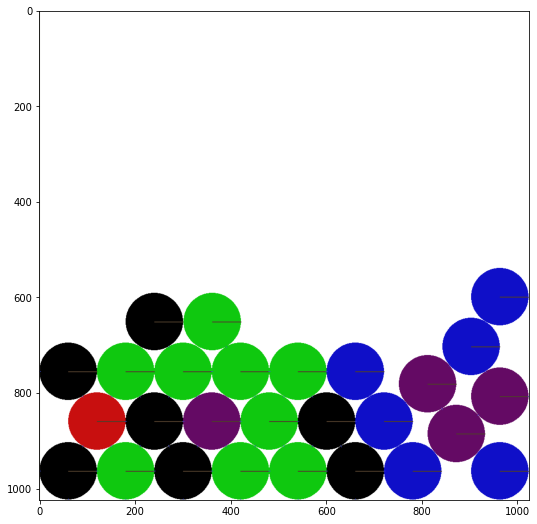

É realizada a captura de uma foto 1D com a função, Camera2D
forma da imagem 1d: (1, 1024, 4)

canal de cores:


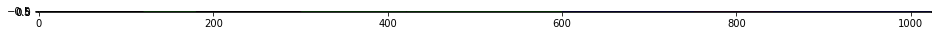

canal da profundidade


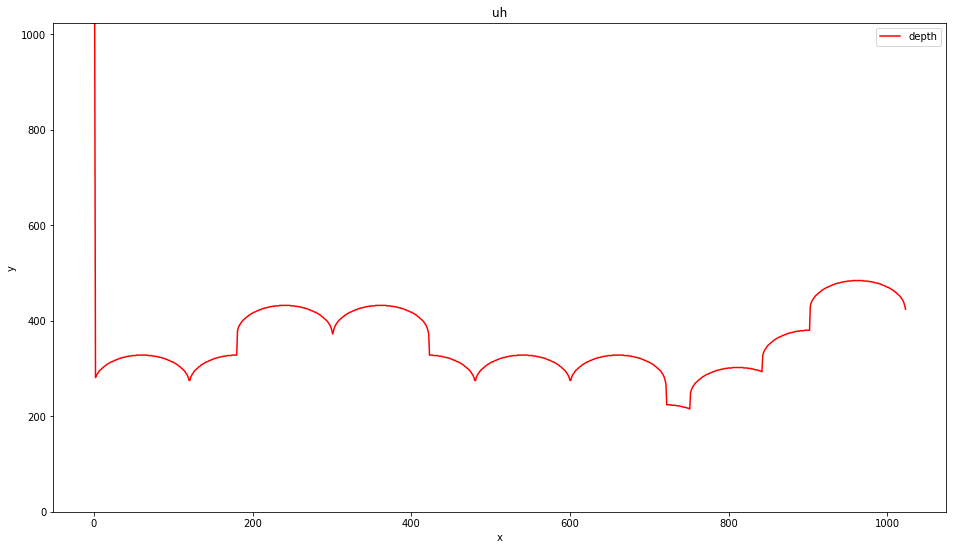

combinamos o canal das cores com o da profundidade para tentar recuperar a imagem


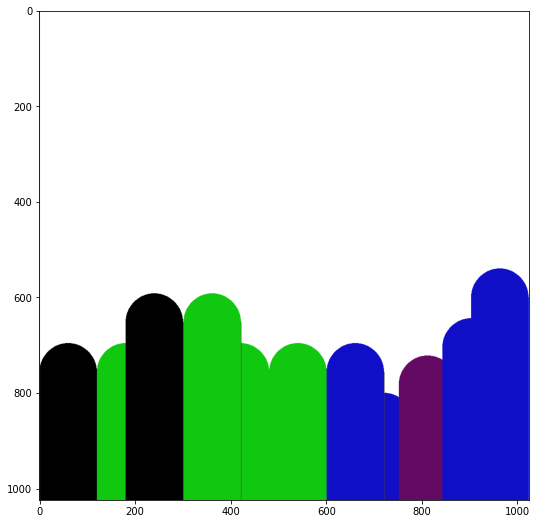

In [10]:
#carregar uma imagem
image=cv2.imread('Caixa_C/caixa000_qtd27.png')

print("imagem carregada")
plt.figure()
plt.imshow(image)
# Show/save figure as desired.
plt.show()

print('É realizada a captura de uma foto 1D com a função, Camera1D')
#bate a foto, gerando uma imagem 1D com canais de cores e profundidade
result=Camera1D(image)

print('forma da imagem 1d:',result.shape)
print("")

print('canal de cores:')
plt.figure()
plt.imshow(result[:,:,:-1].astype('uint8'))
# Show/save figure as desired.
plt.show()

print('canal da profundidade')
plt.figure()
plt.plot(np.squeeze(result[:,:,3], axis=None), 'r-', label='depth')
plt.xlabel('x');
plt.ylabel('y');
plt.title('uh');
plt.legend();
ax = plt.gca()
ax.set_ylim([0, 1024])
plt.show()

print('combinamos o canal das cores com o da profundidade para tentar recuperar a imagem')
plt.figure()
plt.imshow(untransform(result))
# Show/save figure as desired.
plt.show()


## Bater fotos 1D de todas as simulações

In [16]:
origindir='Caixa_C'
outputdir='circle'


filelist=os.listdir(origindir)
for fichier in filelist[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.endswith(".png")):
        filelist.remove(fichier)

filelist=natsort.natsorted(filelist,reverse=False)




In [17]:
counter=0
referencelist=[]
for file in filelist[:51]:
    references={}
    newfilefolder=file[-6:-4]
    newfilename=file[:-4]
    image=cv2.imread(os.path.join(origindir,file))
    result=Camera1D(image)
    savefolder=os.path.join(outputdir,newfilefolder)
    Path(savefolder).mkdir(parents=True, exist_ok=True)
    np.save(os.path.join(savefolder,newfilename), result)
    references['file']=os.path.join(savefolder,newfilename+'.npy')
    references['Y']=int(newfilefolder)
    referencelist.append(references)
    counter=counter+1
    if counter%51 == 0:
        print(counter)
    
df = pd.DataFrame.from_dict(referencelist)

df.to_json(os.path.join(outputdir,outputdir+'.json'))


51


In [18]:
df

,file,Y
0,circle/00/caixa000_qtd00.npy,00
1,circle/01/caixa000_qtd01.npy,01
2,circle/02/caixa000_qtd02.npy,02
3,circle/03/caixa000_qtd03.npy,03
4,circle/04/caixa000_qtd04.npy,04
5,circle/05/caixa000_qtd05.npy,05
6,circle/06/caixa000_qtd06.npy,06
7,circle/07/caixa000_qtd07.npy,07
8,circle/08/caixa000_qtd08.npy,08
9,circle/09/caixa000_qtd09.npy,09
